In [1]:
import translation
import pickle
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import normaltest
import os
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap 
from utils import *
%matplotlib inline

In [2]:
DATA_DIR='./data'
INPUT_DIR='../real_estate_hungary/output'
FILENAME='ForSaleRent_20181101.csv'
INPUT_FILEPATH=os.path.join(INPUT_DIR, FILENAME)
IMG_DIR='./img'

In [3]:
na_hun_equivalent='nincs megadva'

In [4]:
raw=pd.read_csv(INPUT_FILEPATH, encoding='utf8', na_values=na_hun_equivalent)

### Translation from Hungarian to English

In [5]:
raw=translation.transform_naming(raw)

### Data structure/columns
Three categories:
1. Unique ID
2. Possible features
3. Technical columns

In [6]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55146 entries, 0 to 55145
Data columns (total 60 columns):
address                     55120 non-null object
accessibility               14456 non-null object
batch_num                   55146 non-null int64
ceiling_height              37722 non-null object
buses                       36823 non-null object
buses_count                 36823 non-null float64
furnished                   8593 non-null object
cluster_id                  55146 non-null object
property_id                 55146 non-null int64
desc                        54531 non-null object
city_district               55146 non-null int64
smoking                     4822 non-null object
floors                      50258 non-null object
energy_perf_cert            2809 non-null object
balcony                     23573 non-null object
bath_and_wc                 29760 non-null object
type_of_heating             49418 non-null object
equipped                    7926 non-null obje

In [37]:
composite_id=['property_id', 'timestamp']

In [38]:
technical=['property_url', 'cluster_id', 'batch_num', 'page_num', 'max_page', 'max_listing', 'is_ad_active']

In [43]:
possible_features=raw.columns[~raw.columns.isin(technical)&~raw.columns.isin(composite_id)].tolist()

### Drop duplicated records

In [54]:
unique_records=raw[[composite_id[0]]+possible_features].drop_duplicates()
unique_records_idx=unique_records.index
total_records=len(raw)
unique_total_ratio=len(unique_records)/total_records
print('{0:%}'.format(unique_total_ratio))

97.325282%


In [55]:
u_raw=raw.loc[unique_records_idx, possible_features+composite_id]

### Adding unique id column
- Composed from property_id and timestamp

In [56]:
ts_fmt='%Y-%m-%d %H:%M:%S.%f'
u_raw['id']=u_raw['property_id']+u_raw['timestamp'].apply(lambda ts: datetime.datetime.strptime(ts, ts_fmt).timestamp())

In [57]:
u_raw.loc[:,possible_features].head()

,address,accessibility,ceiling_height,buses,buses_count,furnished,desc,city_district,smoking,floors,...,trolley_buses,trolley_buses_count,listing_type,orientation,trams,trams_count,all_night_services,all_night_services_count,year_built,building_floors
0,Budai Bolero II,igen,NaN,103|133E|33,3.0,NaN,| Exkluzív otthon az Ön igényeire szabva! A Bu...,11,NaN,10,...,NaN,NaN,for-sale,nyugat,1,1.0,NaN,NaN,2019,10
1,Csata utca 30.,NaN,3 m-nél alacsonyabb,14|32|105,3.0,NaN,| XIII kerület közkedvelt részén az Árpád-hí...,13,NaN,földszint,...,NaN,NaN,for-sale,északnyugat,1|14,2.0,914|914A,2.0,NaN,5
2,Csata utca 30.,NaN,3 m-nél alacsonyabb,14|32|105,3.0,NaN,| XIII kerület közkedvelt részén az Árpád-hí...,13,NaN,2,...,NaN,NaN,for-sale,délnyugat,1|14,2.0,914|914A,2.0,2018,5
3,Csata utca 30.,NaN,3 m-nél alacsonyabb,14|32|105,3.0,NaN,| XIII kerület közkedvelt részén az Árpád-hí...,13,NaN,1,...,NaN,NaN,for-sale,északnyugat,1|14,2.0,914|914A,2.0,2018,5
4,Csata utca 30.,NaN,3 m-nél alacsonyabb,14|32|105,3.0,NaN,| XIII kerület közkedvelt részén az Árpád-hí...,13,NaN,5,...,NaN,NaN,for-sale,északkelet,1|14,2.0,914|914A,2.0,2018,5


### Available listing types
- for-sale
- for-rent

In [58]:
sale_flt=u_raw.listing_type=='for-sale'
rent_flt=u_raw.listing_type=='for-rent'

### Missing values

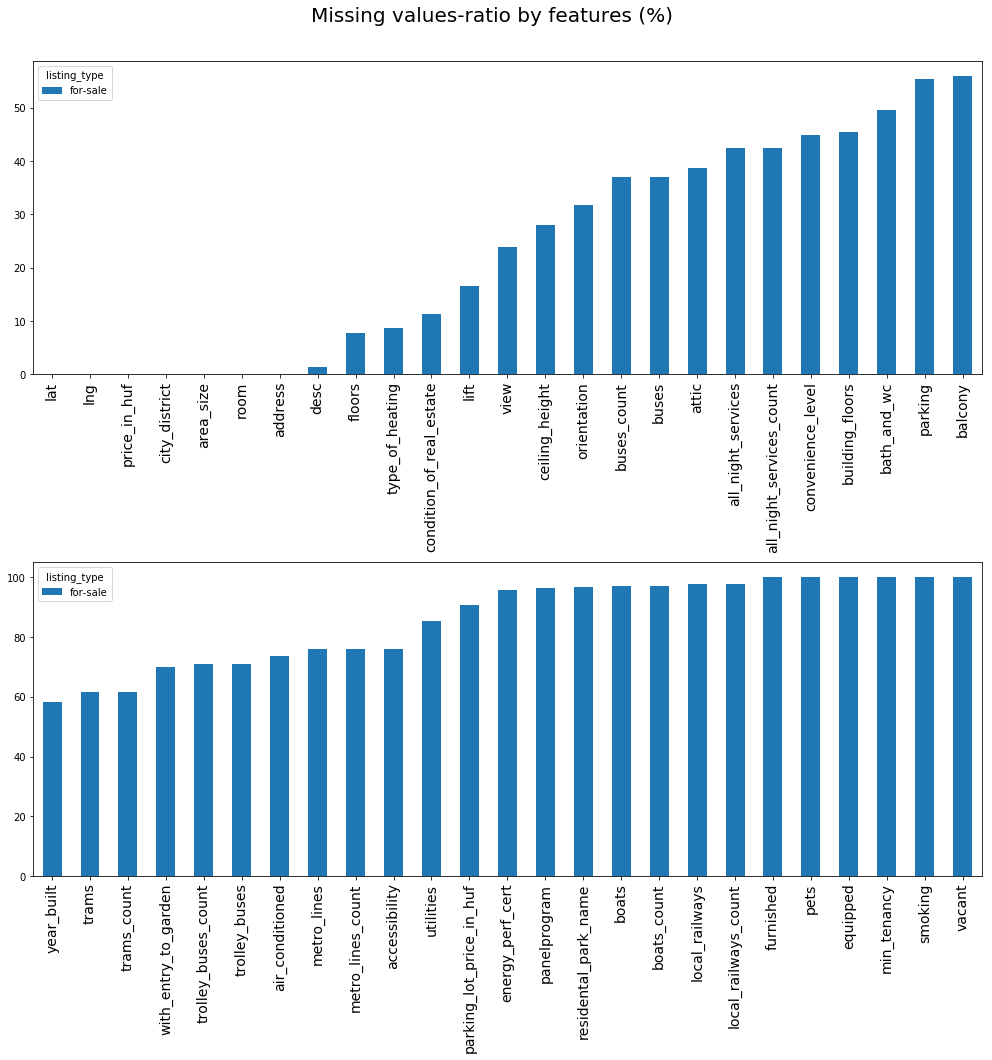

In [61]:
plot_na_ratio(u_raw.loc[sale_flt, possible_features], grouping='listing_type', dest_dir=IMG_DIR)

### Handling missing values
1. No action, using only fully represented variables
2. Impute with mean, median, mode
3. Model different features leveraging of other variables
4. Using *Natural Language Processing* on property description and combine with the 3rd option 

- Fully represented variables:

In [62]:
fully_repr=['id', 'lng', 'lat', 'price_in_huf', 'area_size', 'room', 'city_district', 'address', 'listing_type']

In [63]:
listings=u_raw.loc[:, fully_repr].copy()

In [64]:
listings.dtypes

id               float64
lng              float64
lat              float64
price_in_huf      object
area_size         object
room              object
city_district      int64
address           object
listing_type      object
dtype: object

In [65]:
listings.head()

,id,lng,lat,price_in_huf,area_size,room,city_district,address,listing_type
0,1.567544e+09,19.048690,47.460680,69.9 millió Ft,92 m²,3 + 1 fél,11,Budai Bolero II,for-sale
1,1.565945e+09,19.079060,47.529858,50.3 millió Ft,75 m²,3,13,Csata utca 30.,for-sale
2,1.566792e+09,19.078869,47.529730,49.5 millió Ft,75 m²,3,13,Csata utca 30.,for-sale
3,1.568972e+09,19.079060,47.529858,46.1 millió Ft,71 m²,3,13,Csata utca 30.,for-sale
4,1.568226e+09,19.079060,47.529858,62.9 millió Ft,77 m²,3,13,Csata utca 30.,for-sale


### Convert strings to numeric
- Price - three categories:
    1. Billion (milliárd)
    2. Million (millió)
    3. Hungarian Forint (Ft)<br><br>
- Area size:
    - Remove m$^2$ (square meter)<br><br>
- Price per squaremeter:
    $\frac{price}{area}$<br><br>
- Number of rooms - splitting into two category
    1. Number of full rooms (room >12 m$^2$)
    2. Number of half rooms (room <12 m$^2$)
    3. Adding total number of rooms

In [ ]:
listings['price_in_huf']=raw.price_in_huf.apply(extract_num, thousand_eq='ezer', million_eq='millió', billion_eq='milliárd')
listings['area_size']=raw.area_size.apply(extract_num)
listings['room_lt_12_sqm']=raw.room.apply(lambda x: extract_num(x.split('+')[1]) if '+' in x else 0)
listings['room_ge_12_sqm']=raw.room.apply(lambda x: extract_num(x.split('+')[0]))
listings['room_total']=listings['room_ge_12_sqm']+listings['room_lt_12_sqm']
listings['price_per_sqm']=listings['price_in_huf']/listings['area_size']

- Measurement scales
    - Nominal, category
    - Ordinal
    - Interval
    - Ratio

In [ ]:
num_feat=[i for i in listings if (listings[i].dtype!=object) & (i!='id')]

In [ ]:
listings[num_feat].head(10)

In [ ]:
listings.drop(axis=1, labels='room', inplace=True)

---

### Split listings into listing types

In [ ]:
sale, rent = listings[sale_flt], listings[rent_flt]

### Split *for-sale* dataset into training and test set

In [ ]:
train_sale, test_sale = split_train_test_by_hash(sale, test_ratio=0.2, id_column='id')

In [ ]:
len(train_sale)/(len(train_sale)+len(test_sale))

### Data exploring

In [ ]:
train_sale.describe()

In [ ]:
normaltest(train_sale.avg_price_per_sqm)

In [ ]:
# for bins in range(10, 150, 10):
bins=150
train_sale[['lng', 'lat', 'price_in_huf', 'area_size', 'avg_price_per_sqm', 'room_lt_12_sqm', 'room_ge_12_sqm', 'room_total', 'city_district']].hist(bins=bins, figsize=(20,20))
plt.suptitle('{} bins'.format(bins), fontsize=20, weight=15, y=0.93)
plt.savefig('{0}/{1}_bins_{2}{3}'.format(IMG_DIR, 'histograms', bins, '.png'))
# plt.show()

In [ ]:
train_sale[['price_in_huf', 'area_size']].apply(np.log).hist(bins=bins, figsize=(15,5))
plt.show()

In [ ]:
train_sale['log_price_in_huf']=train_sale.price_in_huf.apply(np.log)
train_sale['log_area_size']=train_sale.area_size.apply(np.log)

In [ ]:
num_feat=[i for i in train_sale if (train_sale[i].dtype!=object) & (i!='id')]

In [ ]:
df=train_sale[num_feat].copy()

In [ ]:
scatter_matrix(df)

In [ ]:
corr=df.corr()
corr.style.background_gradient()

In [ ]:
fig=plt.figure(figsize=(8,8))
ax=fig.gca()
ax.matshow(df.corr(), cmap='Greys')
ax.xaxis.set_ticklabels(ticklabels=['']+df.corr().columns.tolist(), rotation=90, fontsize=15)
ax.yaxis.set_ticklabels(ticklabels=['']+df.corr().columns.tolist(), fontsize=15)
plt.show()

### Longitude, Latitude - Scale: Interval

In [ ]:
min_gps=train_sale[['lng', 'lat']].min()
max_gps=train_sale[['lng', 'lat']].max()

In [ ]:
ax=plt.gca()
train_sale[['lng', 'lat']].plot(kind='scatter', x='lng', y='lat', c='Brown', ax=ax, s=25, alpha=1, linewidth=0.25, edgecolor='Black', figsize=(12,12), xlim=(min_gps['lng'], max_gps['lng']), ylim=(min_gps['lat'], max_gps['lat']))
danube.plot(kind='scatter', x='lng', y='lat', ax=ax, figsize=(12,12), xlim=(min_gps['lng'], max_gps['lng']), ylim=(min_gps['lat'], max_gps['lat']))

- Adding map to the scatter plot

In [ ]:
m = Basemap(urcrnrlat=max_gps['lat'],     # top
              urcrnrlon=max_gps['lng'],   # bottom
              llcrnrlat=min_gps['lat'],     # left
              llcrnrlon=min_gps['lng'],   # right
              epsg=4237)
width = 25
height = 25 #35
fig = plt.gcf()
fig.set_size_inches(width, height)
dpi = 96
xpixels = dpi * width
m.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=xpixels)
plt.scatter(x=train_sale['lng'].values, y=train_sale['lat'].values, s=25, alpha=1, linewidth=0.25, edgecolor='Black')
plt.scatter(x=danube.lng.values, y=danube.lat.values)
# plt.savefig('test.png')
plt.show()

In [ ]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(20,20)
train_sale[['lng', 'lat']].plot(kind='scatter', x='lng', y='lat', ax=axs[1,0], s=25, alpha=0.4, linewidth=0.25, edgecolor='Black')
train_sale[['lng']].hist('lng', ax=axs[0,0], bins=bins, linewidth=0.5, edgecolor='Black', grid=False, sharey=True)
train_sale[['lat']].hist('lat', ax=axs[1,1], bins=bins, linewidth=0.5, edgecolor='Black', grid=False, orientation='horizontal', sharex=True)
axs[0,1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
gps_count=train_sale[['lng', 'lat', 'address']].groupby(['lng', 'lat']).count().sort_values('address', ascending=False)
gps_count.head(10)

In [ ]:
address_count=train_sale[['lng', 'lat', 'address']].groupby(['address']).count().sort_values(['lng', 'lat'], ascending=False)
address_count.head()

#### GPS Coordinates
The issue with the gps coordinates is that if the user has not specified the exact address only the district then gps coordinates point to the center of the district, consequently longitude and latitude pairs are not accurate enough.  
**Solution**: remove these records, since they include too broad set of properties.<br><br>
Four homogeneity levels have been identified:
    1. Fully specified address (contains street number, street name) e.g. Király utca 13.
    2. Residental park is defined e.g. Greenside
    3. Street name is given e.g. Mester utca
    4. Subdistrict name is provided e.g. Aquincum

- Fully specified address

In [ ]:
public_domains=get_public_domain_names()

In [ ]:
street_num_ptrn='|'.join(['.*{}.*\d'.format(d) for d in public_domains])
street_num_mask=train_sale.address.apply(lambda a: bool(re.match(string=str(a), pattern=street_num_ptrn)))
street_num_mask.sum()

In [ ]:
train_sale[street_num_mask].tail()

- Residental park

In [ ]:
residental_park_mask=train_sale.loc[:,'residental_park_name'].notnull()
residental_park_mask.sum()

- Street name

In [ ]:
pub_domain_ptrn='|'.join(['.* {}$'.format(d) for d in public_domains])
public_domains_mask=train_sale.address.apply(lambda a: bool(re.match(string=str(a), pattern=pub_domain_ptrn)))
public_domains_mask.sum()

In [ ]:
train_sale[public_domains_mask].tail()

In [ ]:
train_sale.loc[street_num_mask|residental_park_mask|public_domains_mask, 'address'].count()

In [ ]:
bins=150
fig, axs = plt.subplots(1,2)
train_sale.loc[:, 'lng'].hist(figsize=(15,10), bins=bins, ax=axs[0])
train_sale.loc[street_num_mask|residental_park_mask|public_domains_mask, 'lng'].hist(figsize=(15,10), bins=bins, ax=axs[0], alpha=0.4)
train_sale.loc[:, 'lat'].hist(figsize=(15,10), bins=bins, ax=axs[1])
train_sale.loc[street_num_mask|residental_park_mask|public_domains_mask, 'lat'].hist(figsize=(15,10), bins=bins, ax=axs[1], alpha=0.4)

In [ ]:
normaltest(train_sale.loc[street_num_mask|residental_park_mask|public_domains_mask, 'avg_price_per_sqm'])

### Exporting subdisctrict names with corresponding gps coordianates

In [ ]:
sub_district_map=train_sale.loc[~street_num_mask&~residental_park_mask&~public_domains_mask, ['lng', 'lat', 'address']].dropna().drop_duplicates()
ptrn='|'.join(['.* {} [0-9A-Z]$'.format(d) for d in public_domains])
sub_district_map=sub_district_map[~sub_district_map.address.apply(lambda a: bool(re.match(string=str(a), pattern=ptrn)))]
sd_path=os.path.join(DATA_DIR,'subdistrict_map.csv')
if not os.path.exists(sd_path):
    sub_district_map.to_csv(sd_path, encoding='utf8', index=False)

### Removing outliers
- Standardization:
    - Subtracting mean (centered)
    - Deviding by standard deviation (scaled)

In [ ]:
df=train_sale.loc[:, num_feat].copy()

In [ ]:
scaler=StandardScaler()

In [ ]:
st_arr=scaler.fit_transform(df)

In [ ]:
st_df=pd.DataFrame(st_arr, columns=df.columns)

In [ ]:
fig, axs = plt.subplots(1,11, figsize=(30,10))
for ax, k in zip(axs, st_df):
    ax.scatter(range(len(st_df[k])), st_df[k], marker='o', s=10)
    ax.set_title(k)
    for std in range(-6,7):
        ax.axhline(std, c='r')

In [ ]:
sigma=2.5

In [ ]:
avg_price_mask=(st_df.avg_price_per_sqm.values<=sigma)&(st_df.avg_price_per_sqm.values>=sigma*(-1))
log_price_mask=(st_df.log_price_in_huf.values<=sigma)&(st_df.log_price_in_huf.values>=sigma*(-1))
log_area_mask=(st_df.log_area_size.values<=sigma)&(st_df.log_area_size.values>=sigma*(-1))
lng_mask=(st_df.lng.values<=6)&(st_df.lng.values>=6*(-1))
lat_mask=(st_df.lat.values<=6)&(st_df.lat.values>=6*(-1))

In [ ]:
train_sale.loc[(street_num_mask|residental_park_mask|public_domains_mask)&avg_price_mask&log_price_mask&log_area_mask&lng_mask&lat_mask, num_feat].hist(bins=70, figsize=(20,20))
plt.show()

In [ ]:
len(train_sale.loc[(street_num_mask|residental_park_mask|public_domains_mask)&log_price_mask&log_area_mask, num_feat])/len(train_sale.loc[(street_num_mask|residental_park_mask|public_domains_mask)])

In [ ]:
m = Basemap(urcrnrlat=max_gps['lat'],     # top
              urcrnrlon=max_gps['lng'],   # bottom
              llcrnrlat=min_gps['lat'],     # left
              llcrnrlon=min_gps['lng'],   # right
              epsg=4237)
width = 25
height = 25 #35
fig = plt.gcf()
fig.set_size_inches(width, height)
dpi = 96
xpixels = dpi * width
m.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=xpixels)
ax = plt.gca()
train_sale.loc[(street_num_mask|residental_park_mask|public_domains_mask)&log_price_mask&log_area_mask, num_feat].plot(kind='scatter', x='lng', y='lat', c='avg_price_per_sqm', cmap='hot', alpha=0.7, ax=ax)
# plt.scatter(x=train_sale['lng'].values, y=train_sale['lat'].values, s=25, alpha=1, linewidth=0.25, edgecolor='Black')
# plt.savefig('test.png')
plt.show()

In [ ]:
train_sale.loc[(street_num_mask|residental_park_mask|public_domains_mask)&log_price_mask&log_area_mask, num_feat].plot(kind='scatter', x='lng', y='lat', c='avg_price_per_sqm', cmap='hot', figsize=(15,10), alpha=0.7)

In [ ]:
train_sale=train_sale.loc[mask,:]

In [ ]:
train_sale.loc[mask, ['lat', 'lng']].plot.scatter(x='lng', y='lat', figsize=(10,8))

In [ ]:
train_sale.loc[mask, ['lat', 'lng']].hist(bins=90, figsize=(15,10))

In [ ]:
top_50[45]

In [ ]:
train_sale.loc[train_sale.address==' Király utca',[ 'price_in_huf', 'area_size']].hist(figsize=(10,10), bins=30)

In [ ]:
for train_sale.loc[(train_sale.lng==top_10.iloc[8].name[0])&(train_sale.lat==top_10.iloc[8].name[1])]

In [ ]:
top_8_data

In [ ]:
a=train_sale.loc[(train_sale.lng==top_10.iloc[0].name[0])&(train_sale.lat==top_10.iloc[0].name[1]), 'price_in_huf']/train_sale.loc[(train_sale.lng==top_10.iloc[0].name[0])&(train_sale.lat==top_10.iloc[0].name[1]), 'area_size']

In [ ]:
a.describe()

In [ ]:
a.hist(bins=30)

In [ ]:
?scatter_matrix

In [ ]:
data=train_sale.loc[(train_sale.lng==top_10.iloc[0].name[0])&(train_sale.lat==top_10.iloc[0].name[1]), ['price_in_huf', 'area_size', 'room_lt_12_sqm', 'room_ge_12_sqm']]
scatter_matrix(data, figsize=(20,20), hist_kwds={'bins':30})
plt.show()

In [ ]:
train_sale.loc[(train_sale.lng==top_10.iloc[0].name[0])&(train_sale.lat==top_10.iloc[0].name[1]), ['price_in_huf', 'area_size', 'room_lt_12_sqm', 'room_ge_12_sqm']]

In [ ]:
a.describe()

In [ ]:
train_sale.loc[(train_sale.lng==top_10.iloc[0].name[0])&(train_sale.lat==top_10.iloc[0].name[1])].describe()

### Generate random colors for histogram

In [ ]:
mask=street_num_mask|residental_park_mask|public_domains_mask

In [ ]:
train_sale=train_sale[mask]

In [ ]:
with open(os.path.join(DATA_DIR, 'colors_23'), 'rb') as f:
    rnd_colors=pickle.load(f)

In [ ]:
rnd_colors=np.random.choice(list(mpl.cm.colors.cnames.keys()), size=23, replace=False)

In [ ]:
cmap={k:c for k,c in zip(train_sale.city_district.unique(), rnd_colors)}
train_sale['district_colors']=train_sale['city_district'].map(cmap)
gps_by_district=[train_sale.loc[train_sale.city_district==d, ['lng', 'lat', 'city_district', 'district_colors']] for d in train_sale.city_district.drop_duplicates()]
lng=[df['lng'] for df in gps_by_district]
lat=[df['lat'] for df in gps_by_district]
colors=[df['district_colors'] for df in gps_by_district]

In [ ]:
plt.style.use('ggplot')

In [ ]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(20,20)
for x, y, c in zip(lng, lat, rnd_colors):
    axs[1,0].scatter(x=x, y=y, color=c, linewidth=0.25, edgecolor='Black', alpha=0.5)
axs[0,0].hist(lng, color=rnd_colors, histtype='barstacked', bins=80, linewidth=0.3, edgecolor='Black')
axs[1,1].hist(lat, color=rnd_colors, histtype='barstacked', bins=80, orientation='horizontal', linewidth=0.3, edgecolor='Black')
axs[0,1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
?plt.text

In [ ]:
import seaborn as sns

In [ ]:
plt.figure(figsize=(10,10))
sns.distplot(listings., bins=120)


In [ ]:
listings.loc[sale_flt,['lng', 'lat', 'price_in_huf', 'area_size', 'avg_price_per_sqm', 'room_ge_12_sqm', 'room_lt_12_sqm']].hist(figsize=(20,20), bins=120)

In [ ]:
listings.dtypes

In [ ]:
raw.loc[raw.listing_type=='for-rent' ,['lng', 'lat', 'price_in_huf', 'area_size', 'room', 'city_district', 'address', 'listing_type']]

In [ ]:
from mpl_toolkits.basemap import Basemap 

In [ ]:
import mpld3

In [ ]:
import plotly
plotly.offline.init_notebook_mode()

In [ ]:
plt.scatter(x=raw.loc[raw.listing_type=='for-sale' ,'lng'].values,
            y=raw.loc[raw.listing_type=='for-sale' ,'lat'].values, alpha=1, s=25, marker='o', color='b')
# fig=plt.gcf()
# mpld3.display(fig)
pfig = plotly.tools.mpl_to_plotly(plt.gcf())
plotly.offline.iplot(pfig)

In [ ]:
os.getcwd()

In [ ]:
raw.loc[raw.listing_type=='for-sale' ,['lng', 'lat']].plot(kind='scatter', x='lng', y='lat', figsize=(20,10), alpha=0.05)

In [ ]:
listings['avg_price_per_sqm']=listings['price_in_huf']/listings['area_size']

In [ ]:
danube=load_danube_gps_coordinates(json_path=os.path.join(DATA_DIR, 'danube.geojson'))